This demonstrates all the steps in my candidate selection before conducting visual inspection

In [7]:
import numpy as np
import splat
import wisps.data_analysis as wispd
from wisps.data_analysis import selection_criteria as sel_crt
import shapey
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
import wisps

import matplotlib as mpl

from tqdm import tqdm
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#some functions 
def get_indices(x):
    if x is None :
        return pd.Series({})
    else:
        return  pd.concat([pd.Series(x.indices), pd.Series(x.mags), pd.Series(x.snr)])
    
def get_spt(x):
    if x is None:
        return np.nan
    else:
        return x.spectral_type[0]
#change f-test definition

def f_test_fx(x):
    
    return stats.f.cdf(x, 518, 111)

def box_parameters(idx, spt_range):
    bs=idx.shapes
    b=[x for x in bs if x.shape_name==spt_range][0]
    print ('{}  {} m: {} b: {} s:{}, comp : {}, cont: {}'.format(spt_range, idx,  round(b.coeffs[0], 2), round(b.coeffs[1], 2), round(b.scatter, 2), round(idx.completeness[spt_range], 2),  round(idx.contamination[spt_range], 3)))

In [3]:
#get data
alldata=pd.read_hdf(wisps.LIBRARIES+'/master_dataset.hdf',  key='new')
alldata['f_test']=alldata.x.apply(f_test_fx)

star_ids=alldata[alldata['class_star'] !=0]
stars=wisps.Annotator.reformat_table(star_ids).reset_index(drop=True)
spex=wisps.Annotator.reformat_table(wisps.datasets['spex'])

#cands=pd.read_hdf(wisps.OUTPUT_FILES+'/true_spectra_cands.hdf')
cands0=pd.read_hdf(wisps.LIBRARIES+'/objects_of_interest.hdf', key='all')
cands0=(cands0[~cands0.spectra.isna()]).reset_index(drop=True)
cands=cands0.spectra.apply(get_indices)
cands['grism_id']=cands0.grism_id
cands['spt']=cands0.spectra.apply(get_spt)
cands['line_chi']=cands0.spectra.apply(lambda x : x.line_chi)
cands['spex_chi']=cands0.spectra.apply(lambda x: x.spex_chi)

cands['f_test']=(cands.spex_chi/cands.line_chi).apply(f_test_fx)

#cands_dff['f_test']=(cands_dff['spex_chi']/cands_dff['line_chi']).apply(f_test_fx)

cands=wisps.Annotator.reformat_table(cands)
cands=cands[(cands.spt >=17.) ]
cands_dff=cands.reset_index(drop=True)



spex_df=wisps.Annotator.reformat_table(wisps.datasets['spex']).reset_index(drop=True)
spex_df['f_test']=(spex_df.spex_chi/spex_df.line_chi).apply(f_test_fx)

manj=wisps.Annotator.reformat_table(wisps.datasets['manjavacas']).reset_index(drop=True)
schn=wisps.Annotator.reformat_table(wisps.datasets['schneider']).reset_index(drop=True)
ydwarfs=(manj[manj['spt'].apply(wisps.make_spt_number)>38].append(schn)).reset_index(drop=True)
spex_df['spt']=np.vstack(spex_df['spt'].values)[:,0]
manj['spt']=np.vstack(manj['spt'].values)[:,0]
schn['spt']=np.vstack(schn['spt'].values)[:,0]

cands_dff.grism_id=cands_dff.grism_id.apply(lambda x: x.lower())
stars.grism_id=stars.grism_id.apply(lambda x: x.lower())

cx=cands_dff[cands_dff.grism_id.isin(stars.grism_id)]
cy=stars[stars.grism_id.isin(cx.grism_id)]
cands_dff['spt']=np.vstack(cands_dff['spt'].values)
                           

In [4]:
dt=stars[(stars.f_test< 0.7) &(stars.snr1>=3.)].reset_index(drop=True)
dt['spt']=(dt['spt']).apply(wisps.make_spt_number).apply(float)

In [5]:
len(dt)

34182

In [6]:
#get criteria 
##only run this if new data
#gbhio=sel_crt.save_criteria(conts=dt)
crts=sel_crt.crts_from_file()
contamns=pd.DataFrame([ x.contamination for x in crts.values()])
compls=pd.DataFrame([ x.completeness for x in crts.values()])

contamns.index=[x for x in crts.keys()]
compls.index=[x for x in crts.keys()]

In [7]:
len(alldata), len(stars), len(dt), len(stars[stars.snr1>3.])

(254264, 104346, 34182, 45344)

In [8]:
%%capture
'''
contamns.style.apply(lambda x: ["background-color: #7FDBFF" 
                          if (i >= 0 and (v < 0.1 
                                          and v > 0. )) 
                          else "" for i, v in enumerate(x)], axis = 1)
'''

In [9]:

from collections import OrderedDict
dict(contamns.idxmin(axis=0))# the least contaminated criteria
#add new criteria to avoid repet
to_use_unordered=dict(contamns.idxmin(axis=0))
ordered=OrderedDict((k, to_use_unordered[k]) for k in ['M7-L0', 'L0-L5', 'L5-T0', 'T0-T5', 'T5-T9', 'Y dwarfs', 'subdwarfs'])

In [10]:
#copy paste the best indices here manually

to_use=  {value: key for key, value in dict(ordered).items() if key !='trash'}

In [11]:
#check for repeated keywords
to_use

{'CH_4/H-Cont H_2O-1+H_2O-2/J-Cont': 'M7-L0',
 'H-cont/H_2O-2 CH_4/H-Cont': 'L0-L5',
 'CH_4/H_2O-2 H_2O-2+CH_4/J-Cont': 'L5-T0',
 'CH_4/H_2O-2 H_2O-1+H_2O-2/J-Cont': 'T0-T5',
 'H-cont/H_2O-1 H_2O-1+CH_4/H-Cont': 'T5-T9',
 'H_2O-1/J-Cont H_2O-1+CH_4/H-Cont': 'Y dwarfs',
 'H_2O-1/J-Cont H-cont/J-Cont': 'subdwarfs'}

In [12]:
len(to_use)

7

In [13]:
import pickle
#save the random forest
output_file=wisps.OUTPUT_FILES+'/best_indices_to_use.pkl'
with open(output_file, 'wb') as file:
    pickle.dump(to_use,file)

In [14]:
fp={}

In [15]:
def plot_index_box(index_name, box_name, ax):
    
    #get the index and the box
    idx=crts[index_name]
    bx=[x for x in idx.shapes if x.shape_name==box_name][0]
    
    xkey=idx.xkey
    ykey=idx.ykey

    to_use_df=spex_df
    if box_name.lower()=='y dwarfs':
        to_use_df=ydwarfs
    if box_name.lower()=='subdwarfs':
        to_use_df=wisps.Annotator.reformat_table(idx.subdwarfs)
        to_use_df['spt']=17
        
    xlim=[ bx.xrange[0]-.5*abs(np.ptp(bx.xrange)), bx.xrange[1]+.5*abs(np.ptp(bx.xrange))]
    ylim=[ bx.yrange[0]-.5*abs(np.ptp(bx.yrange)), bx.yrange[1]+.5*abs(np.ptp(bx.yrange))]
    
    if box_name.upper()=='T5-T9':
        print ('changin scale')
        print (bx.xrange[1])
        xlim=[ bx.xrange[0]-0.2*abs(np.ptp(bx.xrange)), np.round(bx.xrange[1]+0.2*abs(np.ptp(bx.xrange)))]

    
    #remove nans from background
    bckgrd= dt[[xkey, ykey]].replace(-np.inf, np.nan).replace(np.inf, np.nan).dropna()
    
    bckgrd=bckgrd[(bckgrd[xkey].between(xlim[0], xlim[1])) & (bckgrd[ykey].between(ylim[0], ylim[1]))]

    h=ax.hist2d(bckgrd[xkey].apply(float).values, bckgrd[ykey].apply(float).values, cmap='gist_yarg')
    
    cands_slctd, cands_bools=bx._select(np.array([cands_dff[xkey].values,cands_dff[ykey].values]))
   
    trash_slctd, trsh_bools=bx._select(np.array([dt[xkey].values, dt[ykey].values]))
    
    #simul_slctd, simul_bools=bx._select(np.array([simulated_data[xkey].values, simulated_data[ykey].values]))
    
    
    cands_in_that_class_bool=(cands_dff[ cands_bools]).spt.apply(lambda x: wisps.is_in_that_classification(x, box_name))
    
    spexs_slctd_in_that_class_bool= (to_use_df).spt.apply(lambda x: wisps.is_in_that_classification(x, box_name))
    
    #simulated_in_that_class_bool=(simulated_data[simul_bools]).spt.apply(lambda x: wisps.is_in_that_classification(x, box_name))
    
    if box_name.lower()=='subdwarfs':
         spexs_slctd_in_that_class_bool=np.ones(len(to_use_df), dtype=bool)
    
    
    
    
    cands_in_that_class=np.array([cands_slctd[0][cands_in_that_class_bool], cands_slctd[1][cands_in_that_class_bool]])
    
    #simulated_in_that_class= np.array([simul_slctd[0][simulated_in_that_class_bool], simul_slctd[1][simulated_in_that_class_bool]])
    
    spexs_slctd_in_that_class=np.array([to_use_df[xkey][spexs_slctd_in_that_class_bool], to_use_df[ykey][spexs_slctd_in_that_class_bool]])
    

    #ax.scatter( simulated_in_that_class[0],    simulated_in_that_class[1], facecolors='none', s=10, 
    #           edgecolors='#001f3f', label='simulated')
    
    ax.scatter(spexs_slctd_in_that_class[0], spexs_slctd_in_that_class[1], facecolors='#0074D9',  label='SpeX', s=30.)
    
    ax.scatter(cands_dff[xkey], cands_dff[ykey], marker='x', facecolors='#FF851B', s=40., alpha=0.5)
    
    
    ax.scatter( cands_in_that_class[0],    cands_in_that_class[1], marker='x', facecolors='#FF851B', s=40, 
               edgecolors='#FF4136', label='candidates')
    
    
    
    
    bx.color='None'
    bx.alpha=1.
    bx.linewidth=3
    bx.linestyle='-'
    bx.edgecolor='#0074D9'
    bx.plot(ax=ax, only_shape=True, highlight=False)
    
    cb = plt.colorbar(h[3], ax=ax, orientation='horizontal')
    cb.set_label('Counts in bin', fontsize=16)
    
    plt.tight_layout()
    
    ax.set_xlabel(r'$'+str(idx.name.split(' ')[0])+'$', fontsize=14)
    ax.set_ylabel(r'$'+str(idx.name.split(' ')[1])+'$', fontsize=14)
    
    ax.set_title(box_name, fontsize=18)
    
    xbuffer=np.nanstd(to_use_df[[xkey,ykey]])
    
   
    
    ax.minorticks_on()
    

    if (trash_slctd.shape[1])==0:
        fprate=0.0
    else:
        fprate=(trash_slctd.shape[1]- cands_slctd.shape[1])/trash_slctd.shape[1]
        if box_name.lower()=='subdwarfs':
                fprate=1.
    
    fp[box_name]=  fprate
    
        
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    
    plt.tight_layout()
    print (' {} selected {}'.format(box_name, len(bx.select( bckgrd))))
    
    return {str(box_name): bx}
    
    

 M7-L0 selected 3736
 L0-L5 selected 2454
 L5-T0 selected 737
 T0-T5 selected 51
changin scale
12.351100394028286
 T5-T9 selected 2
 Y dwarfs selected 2
 subdwarfs selected 7070


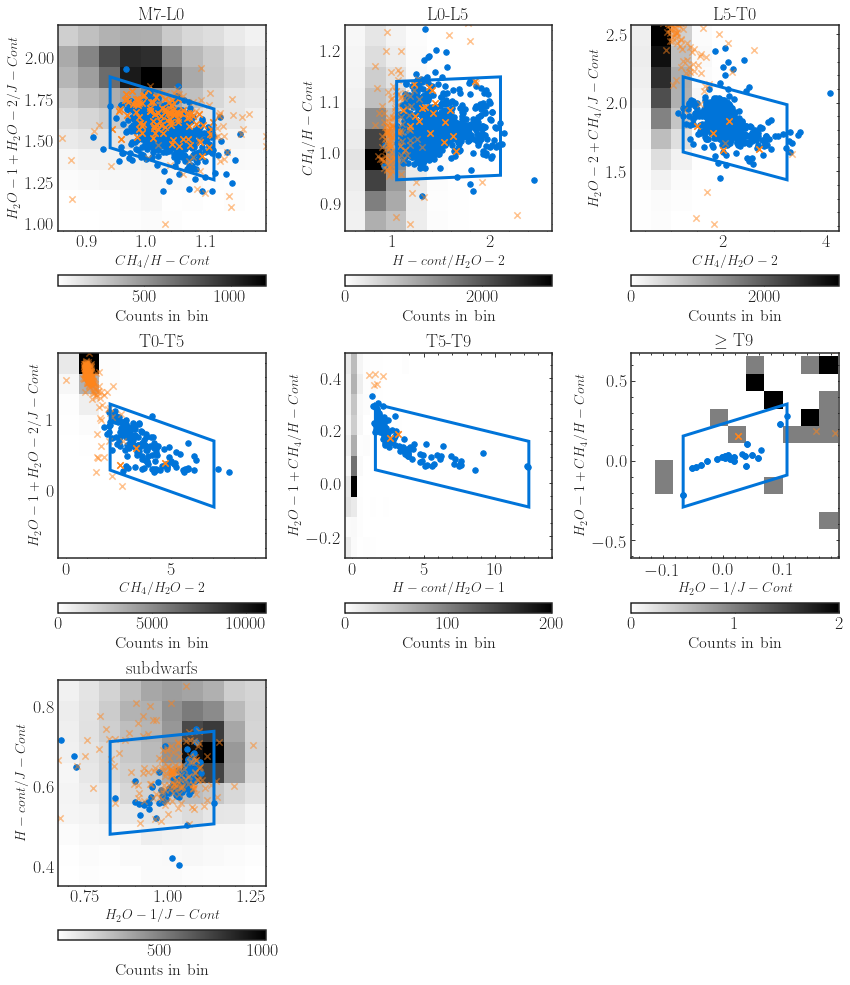

In [16]:
fig, ax=plt.subplots(nrows=3, ncols=3, figsize=(12, 14))

bxs=[]
for idx, k in enumerate(to_use.keys()):
    b=plot_index_box( k, to_use[k], np.concatenate(ax)[idx])
    bxs.append(b)



plt.tight_layout()


fig.delaxes(np.concatenate(ax)[-1])
fig.delaxes(np.concatenate(ax)[-2])

np.concatenate(ax)[-4].set_title(r'$\geq$ T9 ', fontsize=18)
#subdindx_index_crt=crts['H_2O-1/J-Cont H_2O-2/H_2O-1']
#subdrfs=wisps.Annotator.reformat_table(dummy_index_crt.subdwarfs)
#tpls=wisps.Annotator.reformat_table(spex_df[spex_df.metallicity_class.isna()])
#a=np.concatenate(ax)[-1]
#tpls=tpls[tpls.spt>16]

#a.scatter(dt[subdindx_index_crt.xkey], dt[subdindx_index_crt.ykey], s=1., c='#111111', alpha=0.1)
#a.scatter(tpls[subdindx_index_crt.xkey], tpls[subdindx_index_crt.ykey], marker='+', facecolors='#0074D9',  label='SpeX', s=5.)
#a.scatter(subdrfs[subdindx_index_crt.xkey], subdrfs[subdindx_index_crt.ykey], marker='+', facecolors='#2ECC40',  label='SpeX', s=30.)


#a.set_xlim([0., 1.35])
#a.set_ylim([0., 1.25])
#a.set_title('subdwarfs', fontsize=18)
#a.set_xlabel(r'$'+str(subdindx_index_crt.name.split(' ')[0])+'$', fontsize=15)
#a.set_ylabel(r'$'+str(subdindx_index_crt.name.split(' ')[1])+'$', fontsize=15)
    

plt.savefig(wisps.OUTPUT_FIGURES+'/index_index_plots.pdf', bbox_inches='tight', rasterized=True)

In [17]:
common=dt[dt.grism_id.isin(cands.grism_id)]

In [18]:
#.grism_id.to_csv('/users/caganze/desktop/true_brown_dwarfs.csv')

In [19]:
bx_dict={}
for b in bxs:
    bx_dict.update(b)

In [20]:
#invert to use
inv_to_use = {v: k for k, v in to_use.items()}

In [21]:
ncandidates=[]
for spt_range in bx_dict.keys():
    idx_name=inv_to_use[spt_range]
    idx=crts[idx_name]
    s, bools=(bx_dict[spt_range])._select(np.array([dt[idx.xkey].values, dt[idx.ykey].values]))
    ncandidates.append(dt[bools])

In [22]:
candsss=(pd.concat(ncandidates).drop_duplicates(subset='grism_id'))
cands_dff.grism_id=cands_dff.grism_id.apply(lambda x: x.lower())
good_indices=[crts[x] for x in inv_to_use.values()]

In [23]:
len(candsss), len(candsss[candsss.grism_id.isin(cands_dff.grism_id) & (candsss.spt.apply(wisps.make_spt_number)>16)])

(11328, 157)

In [24]:
len(candsss.drop_duplicates('grism_id'))/len(alldata)

0.04455211905735771

In [25]:
len(candsss[candsss.grism_id.isin(cands_dff.grism_id) & (candsss.spt.apply(wisps.make_spt_number)>=17)])

157

In [26]:
candsss.to_pickle(wisps.OUTPUT_FILES+'/selected_by_indices.pkl')

In [27]:
#print out table
def round_tuple(tpl, n=2):
    return round(tpl[0], n), round(tpl[1],n)

for sindex, k in zip(good_indices, to_use.keys()):
   
    spt_range=to_use[k]
    bs=sindex.shapes
    bs=[x for x in bs if x.shape_name==spt_range]

    bx=bs[0]
    
    print (" {} & {} &  {} & {} & {} & {} & {} & {} & {}  & {} \\\ ".format(spt_range,sindex.xkey, sindex.ykey, 
                                                                           round_tuple(bx.vertices[0]), round_tuple(bx.vertices[1])
                                                                          , round_tuple(bx.vertices[2]), round_tuple(bx.vertices[3]),
                                                                          round(sindex.completeness[spt_range], 2), 
                                                                            round(sindex.contamination[spt_range], 6), 
                                                                           round(fp[spt_range],6)))
    

 M7-L0 & CH_4/H-Cont &  H_2O-1+H_2O-2/J-Cont & (0.94, 1.89) & (1.11, 1.69) & (1.11, 1.26) & (0.94, 1.46) & 0.97 & 0.112426  & 0.97136 \\ 
 L0-L5 & H-cont/H_2O-2 &  CH_4/H-Cont & (1.03, 1.14) & (2.11, 1.15) & (2.11, 0.95) & (1.03, 0.95) & 0.97 & 0.067364  & 0.977588 \\ 
 L5-T0 & CH_4/H_2O-2 &  H_2O-2+CH_4/J-Cont & (1.23, 2.19) & (3.24, 1.99) & (3.24, 1.44) & (1.23, 1.64) & 0.95 & 0.02061  & 0.986431 \\ 
 T0-T5 & CH_4/H_2O-2 &  H_2O-1+H_2O-2/J-Cont & (2.1, 1.22) & (7.05, 0.7) & (7.05, -0.23) & (2.1, 0.29) & 0.97 & 0.001726  & 0.843137 \\ 
 T5-T9 & H-cont/H_2O-1 &  H_2O-1+CH_4/H-Cont & (1.62, 0.3) & (12.35, 0.16) & (12.35, -0.09) & (1.62, 0.05) & 0.96 & 7e-05  & 0.0 \\ 
 Y dwarfs & H_2O-1/J-Cont &  H_2O-1+CH_4/H-Cont & (-0.07, 0.15) & (0.11, 0.35) & (0.11, -0.09) & (-0.07, -0.29) & 0.91 & 3.5e-05  & 0.5 \\ 
 subdwarfs & H_2O-1/J-Cont &  H-cont/J-Cont & (0.83, 0.71) & (1.14, 0.74) & (1.14, 0.51) & (0.83, 0.48) & 0.94 & 0.226523  & 1.0 \\ 


In [28]:
cands_dff=(cands_dff[np.logical_and(cands_dff['snr1'] >=3., cands_dff['spt'] >=17)]).sort_values('spt')
spex_df=spex_df.sort_values('spt')

star_snr=stars[['snr1', 'snr2', 'snr3', 'snr4']].apply(np.log10).dropna()
star_snr=(star_snr[star_snr.snr1.between(-1, 4) & star_snr.snr3.between(-1, 4) & star_snr.snr4.between(-1, 4)]).reset_index(drop=True)

In [29]:
spex_df=spex_df[spex_df.spt >=16]

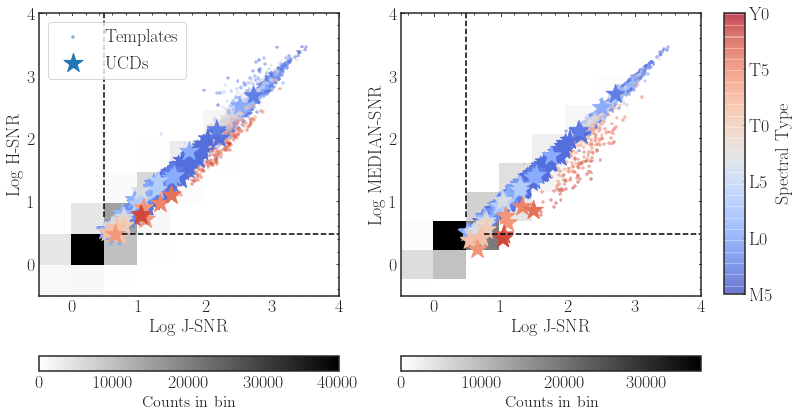

In [30]:
fig, (ax, ax1)=plt.subplots(ncols=2, figsize=(10, 6))

h=ax.hist2d(star_snr['snr1'], star_snr['snr3'], cmap='gist_yarg', bins=10, label='Point Sources')

cb = plt.colorbar(h[3], ax=ax, orientation='horizontal')
cb.set_label('Counts in bin', fontsize=16)
plt.tight_layout()

#ax.scatter(star_snr['snr1'],  star_snr['snr4'], s=1., c='k', alpha=0.1, 
#            label='3D-HST or WISP')


ax.scatter(spex_df['snr1'].apply(np.log10), spex_df['snr3'].apply(np.log10),
           marker='+', s=15, c=spex_df.spt, 
           cmap='coolwarm', label='Templates', alpha=0.5, vmin=15, vmax=40) 
ax.scatter(cands_dff['snr1'].apply(np.log10), cands_dff['snr3'].apply(np.log10), 
           c=cands_dff['spt'], s=400,  marker='*', cmap='coolwarm', label='UCDs'
           , vmin=15, vmax=40) 
ax.set_xlim([-0.5, 4])
ax.set_ylim([-0.5, 4])
ax.set_xlabel('Log J-SNR', fontsize=18)
ax.set_ylabel('Log H-SNR', fontsize=18)
ax.legend(fontsize=18, loc='upper left')

ax.axhline(np.log10(3), c='k', xmin=np.log10(3)-0.2, linestyle='--')
ax.axvline(np.log10(3), c='k', ymin=np.log10(3)-0.2, linestyle='--')



#ax1.scatter(stars['snr1'].apply(np.log10), stars['snr4'].apply(np.log10), s=1., c='k', alpha=0.1, 
#            label='3D-HST or WISP')

h1=ax1.hist2d(star_snr['snr1'], star_snr['snr4'], cmap='gist_yarg', bins=10, label='Point Sources')
mp=ax1.scatter(spex_df['snr1'].apply(np.log10), spex_df['snr4'].apply(np.log10), marker='+', s=15, c=spex_df.spt, 
            cmap='coolwarm', label='Templates', alpha=0.5, vmin=15, vmax=40) 

ax1.scatter(cands_dff['snr1'].apply(np.log10), cands_dff['snr4'].apply(np.log10), 
                       c=cands_dff['spt'], s=400, marker='*', cmap='coolwarm', label='UCDs',  vmin=15, vmax=40) 
ax1.set_xlim([-0.5, 4])
ax1.set_ylim([-0.5, 4])
ax1.set_xlabel(' Log J-SNR', fontsize=18)
ax1.set_ylabel('Log MEDIAN-SNR', fontsize=18)
#ax.legend(fontsize=18)

ax1.axhline(np.log10(3), c='k', xmin=np.log10(3)-0.2, linestyle='--')
ax1.axvline(np.log10(3), c='k', ymin=np.log10(3)-0.2, linestyle='--')

cb1 = plt.colorbar(h1[3], ax=ax1, orientation='horizontal')
cb1.set_label('Counts in bin', fontsize=16)
plt.tight_layout()

cax = fig.add_axes([1.01, 0.31, .03, 0.65])
cbar=plt.colorbar(mp, cax=cax, orientation='vertical')
cbar.ax.set_ylabel(r'Spectral Type', fontsize=18)

ax.minorticks_on()
ax1.minorticks_on()

#cbar.ax.set_yticks([ 17, 20, 25, 30, 35, 40])
cbar.ax.set_yticklabels(['M5', 'L0', 'L5', 'T0', 'T5', 'Y0'])
plt.tight_layout()

plt.savefig(wisps.OUTPUT_FIGURES+'/snr_cutplots.pdf', bbox_inches='tight', rasterized=True)

In [1]:
import wisps
def format_name(name):
		n=name.split('/')[-1]
		n=n.split('.jpeg')[0]
		if n.startswith('par'): 
			n=n.replace('_', '-', 1)
		if not n.startswith('par'):
			n=n.replace('_', '-', 2)
		return n

In [3]:
s1=wisps.Source(name=format_name('par371_00034.jpeg'))
s2=wisps.Source(name=format_name('par137_00027.jpeg'))

In [4]:
s1.dof, s2.dof, s1.splat_spectrum.instrument, s2.splat_spectrum.instrument, len(s2.wave), len(s1.wave)

(198.0, 60.0, 'WFC3-G141', 'WFC3-G141', 120, 254)

In [5]:
s2.splat_spectrum.slitwidth, s1.splat_spectrum.slitwidth,  s1.splat_spectrum.pixelscale, s2.splat_spectrum.pixelscale

(<Quantity 0.25556652 arcsec>,
 <Quantity 0.16422493 arcsec>,
 <Quantity 0.128 arcsec>,
 <Quantity 0.128 arcsec>)

In [6]:
s2.spectral_type, s2.index_type, 

(array([16.,  1.]), ('M6.8', 0.5369430195329177))

In [21]:
s2.calculate_distance(use_index_type=False, use_spt_unc=True )

In [22]:
s2.distance

{'val': <Quantity 1698.0621694 pc>, 'er': <Quantity 644.38848241 pc>}